# 1. Load Library

In this section we import all the necessary libraries.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os
import random
import pickle

from scipy.sparse import csr_matrix, vstack
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from xgboost import XGBRegressor                  # XGBoost for GPU processing
from sklearn.preprocessing import OneHotEncoder     # Support Sparse Matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay   # Classification metrics

print('Libraries loaded successfully')

Libraries loaded successfully


# 2. Load Dataset

Load the dataset (e.g., a CSV file) and preview it.

In [63]:
# Download from Kaggle or load preprocessed data
current_path = None
if not current_path:
    path = kagglehub.dataset_download("samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc")

    files = os.listdir(path)
    csv_path = os.path.join(path, 'GDSC_Cleaned.csv')
    df = pd.read_csv(csv_path)
    df.head()
else:
    path = current_path
    with open(os.path.join(path, 'GDSC_Cleaned.pkl'), 'rb') as f:
        df = pickle.load(f)

print("Path to dataset files:", path)

Path to dataset files: /Users/shijie/.cache/kagglehub/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc/versions/2


In [64]:
df.head()

,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.592660,-1.516647,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.734047,-0.807232,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.582439,-1.570016,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication


In [65]:
# Data preprocessing
categorical_features = ['GDSC Tissue descriptor 1',
                        'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)',
                        'TARGET', 'TARGET_PATHWAY']
full_features = categorical_features + ['Microsatellite instability Status (MSI)', 'CNA', 'Gene Expression', 'Methylation']

data = df.copy()
# Filter highly skewed drugs: skewness of LN_IC50 should be ≤ 2
drug_skew = data.groupby("DRUG_NAME")["LN_IC50"].skew()
abs_skews = drug_skew.abs()
threshold = 2
low_skew_drugs = abs_skews[abs_skews <= threshold].index
data_filtered = data[data["DRUG_NAME"].isin(low_skew_drugs)].copy()
print(f"Using absolute skewness ≤ {threshold:.2f} as low‑skew cutoff.")
all_drugs = data["DRUG_NAME"].unique()
print(f"Filter {len(all_drugs) - len(low_skew_drugs)} drugs.")

# Could be adjusted to use all features
# data_filtered = data_filtered[data_filtered['DRUG_ID'] == 1003]
data_filtered = data_filtered[data_filtered['DRUG_ID'].isin([1003, 1004, 1005, 1006, 1007])]
X = data_filtered[full_features]
# X = data_filtered[categorical_features]

# One-Hot Encoding for X
X_encoder = OneHotEncoder(sparse_output=True)
X_encoded = X_encoder.fit_transform(X)
# X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

y = data_filtered["LN_IC50"]
print(y.value_counts())

Using absolute skewness ≤ 2.00 as low‑skew cutoff.
Filter 6 drugs.
LN_IC50
-3.452815    1426
-3.354018       2
-1.463887       1
 5.157932       1
 3.413041       1
             ... 
-1.894049       1
-1.573621       1
-2.087724       1
-2.909054       1
-2.794347       1
Name: count, Length: 2752, dtype: int64


# 3. Define Base Learner

Define the base learner that will be used in the different learning methods. For example, a simple Logistic Regression classifier.

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define the base learner as random forest
base_learner = RandomForestRegressor(n_estimators=100,
        max_depth=10)

print('Base learner defined:')
print(base_learner)

Base learner defined:
RandomForestRegressor(max_depth=10)


# 4. Offline Learning Method

Implement the offline (batch) learning method where the base learner is trained on the entire dataset.

MSE of the model: 2.18
r2 of the model: 0.74


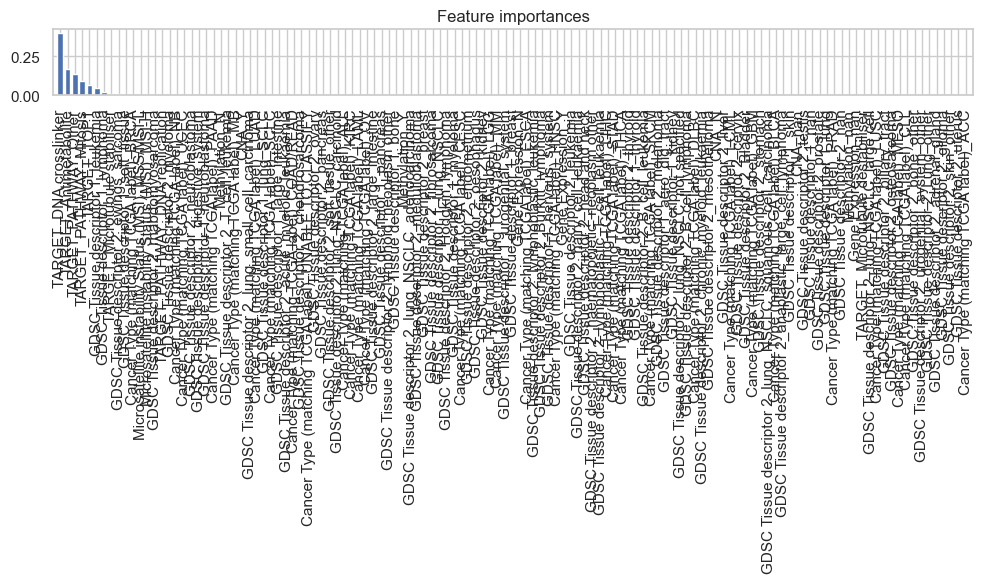

In [67]:
from sklearn.metrics import mean_squared_error, r2_score

categorical_features = ['GDSC Tissue descriptor 1',
                        'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)',
                        'TARGET', 'TARGET_PATHWAY']
# tmp = df.copy()
# tmp = tmp[tmp['DRUG_ID'] == 1003]
# X = tmp[categorical_features]
# y = tmp['LN_IC50']

# Convert categorical features to numerical using one-hot encoding
# X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Train the base learner
base_learner.fit(X_train, y_train)

# evaluate the model
y_pred = base_learner.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE of the model: {mse:.2f}')
print(f'r2 of the model: {r2:.2f}')

# Visualize the feature importance
importances = base_learner.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_encoder.get_feature_names_out(X_encoder.feature_names_in_)[indices]
# features = X_encoded.columns[indices]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_encoded.shape[1]), importances[indices], align="center")
plt.xticks(range(X_encoded.shape[1]), features, rotation=90)
plt.xlim([-1, X_encoded.shape[1]])
plt.tight_layout()
plt.show()

# 5. Passive Learning Method

Implement the passive learning method. This method randomly select instances from sample space for model training.

In [68]:
def random_sampling(X, y, n_samples, random_state):
    """
    Perform random sampling from the dataset in a sparse-compatible way.
    
    Parameters:
    -----------
    X : {array-like, sparse matrix, dataframe} of shape (n_samples, n_features)
        The input samples
    y : array-like of shape (n_samples,)
        The target values
    n_samples : int
        Number of samples to select
    random_state : int or None, optional (default=None)
        Controls the randomness of the sampling
        
    Returns:
    --------
    X_sampled : selected samples
    X_remaining : remaining samples
    y_sampled : selected target values
    y_remaining : remaining target values
    """
    np.random.seed(random_state)
    indices = np.random.permutation(X.shape[0])
    sample_idx = indices[:n_samples]
    remaining_idx = indices[n_samples:]

    if hasattr(X, 'iloc'):  # pandas DataFrame
        X_sampled = X.iloc[sample_idx]
        X_remaining = X.iloc[remaining_idx]
    else:  # numpy array
        X_sampled = X[sample_idx]
        X_remaining = X[remaining_idx]

    if hasattr(y, 'iloc'):  # pandas DataFrame
        y_sampled = y.iloc[sample_idx]
        y_remaining = y.iloc[remaining_idx]
    else:
        y_sampled = y[sample_idx]
        y_remaining = y[remaining_idx]

    return X_sampled, X_remaining, y_sampled, y_remaining

In [70]:
from sklearn.metrics import mean_squared_error, r2_score

mse_passive = []
r2_passive = []

test_size = 0.2             # Percentage of data for testing
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments

# Convert categorical features to numerical using one-hot encoding
# X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

for seed in range(n_runs):
    base_learner = RandomForestRegressor(n_estimators=100,
        max_depth=10,
        random_state=seed)
    data = X.copy()
    labels = y.copy()

    # Split the data into training, validation, and testing sets
    X_train_pool, X_test, y_train_pool, y_test = train_test_split(
        X_encoded, y, test_size=test_size, random_state=seed)
    X_train, X_pool, y_train, y_pool = train_test_split(
        X_train_pool, y_train_pool, train_size=initial_train_size, random_state=seed)
    overall_length = X_pool.shape[0]

    overall_mse = []
    overall_r2 = []
    predict_mean = []
    # add the most uncertain sample to the training set
    while X_train.shape[0] < overall_length:
        # Train the model
        model = base_learner.fit(X_train, y_train)

        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        # Calculate the mean squared error and R^2 score
        overall_mse.append(mean_squared_error(y_test, y_pred))
        overall_r2.append(r2_score(y_test, y_pred))
        
        # Randomly select a sample from the training set
        X_new, X_pool, y_new, y_pool = random_sampling(
            X_pool, y_pool, n_samples=1, random_state=seed)

        # Update the training set with the new sample
        X_train = vstack([X_train, X_new])
        y_train = pd.concat([y_train, y_new], ignore_index=True)
        
        # Verbose output
        if X_train.shape[0] % 100 == 0:
            print(f"Training size: {X_train.shape[0]}, MSE: {overall_mse[-1]:.2f}, R2: {overall_r2[-1]:.2f}")

    mse_passive.append(overall_mse)
    r2_passive.append(overall_r2)
    print(f"Seed {seed} done")

Training size: 200, MSE: 2.50, R2: 0.71
Training size: 300, MSE: 2.43, R2: 0.72
Training size: 400, MSE: 2.38, R2: 0.72
Training size: 500, MSE: 2.33, R2: 0.73
Training size: 600, MSE: 2.24, R2: 0.74
Training size: 700, MSE: 2.17, R2: 0.75
Training size: 800, MSE: 2.12, R2: 0.76
Training size: 900, MSE: 2.11, R2: 0.76
Training size: 1000, MSE: 2.08, R2: 0.76
Training size: 1100, MSE: 2.09, R2: 0.76
Training size: 1200, MSE: 2.08, R2: 0.76
Training size: 1300, MSE: 2.05, R2: 0.76
Training size: 1400, MSE: 2.05, R2: 0.76
Training size: 1500, MSE: 2.04, R2: 0.76
Training size: 1600, MSE: 2.04, R2: 0.76
Training size: 1700, MSE: 2.03, R2: 0.77
Training size: 1800, MSE: 2.02, R2: 0.77
Training size: 1900, MSE: 2.00, R2: 0.77
Training size: 2000, MSE: 1.99, R2: 0.77
Training size: 2100, MSE: 1.98, R2: 0.77
Training size: 2200, MSE: 1.99, R2: 0.77
Training size: 2300, MSE: 1.99, R2: 0.77
Training size: 2400, MSE: 1.98, R2: 0.77
Training size: 2500, MSE: 1.97, R2: 0.77
Training size: 2600, MSE

Mean MSE of the model: 1.98
Mean r2 of the model: 0.77


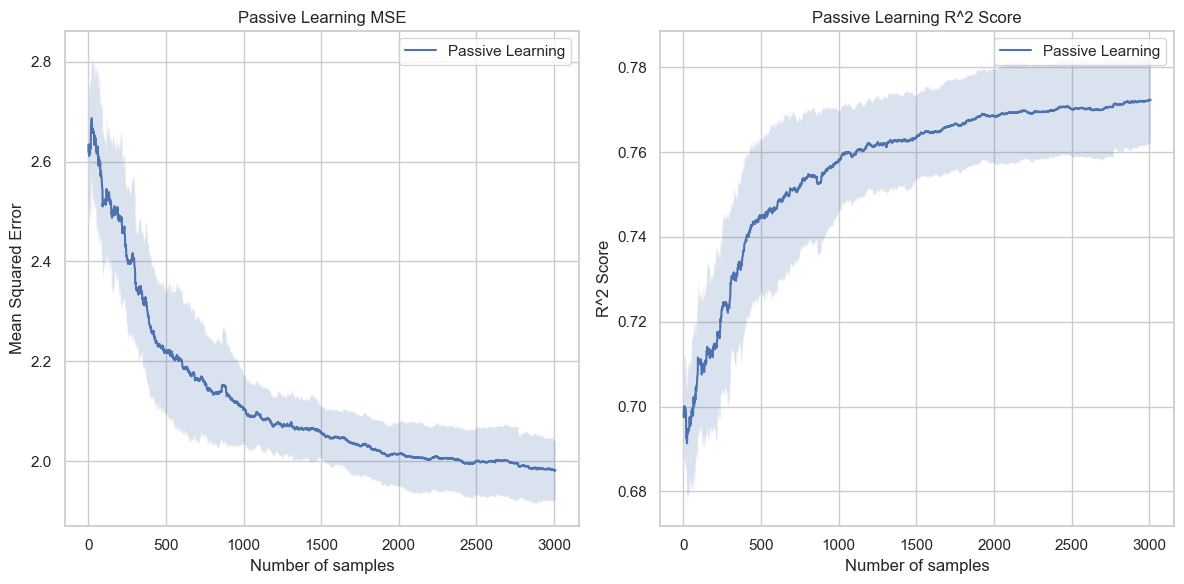

In [71]:
# Calculate the mean and standard deviation of MSE and R^2 scores
mse_passive = np.array(mse_passive)
mean_mse_passive = np.mean(mse_passive, axis=0)
std_mse_passive = np.std(mse_passive, axis=0)
r2_passive = np.array(r2_passive)
mean_r2_passive = np.mean(r2_passive, axis=0)
std_r2_passive = np.std(r2_passive, axis=0)
print(f'Mean MSE of the model: {mean_mse_passive[-1]:.2f}')
print(f'Mean r2 of the model: {mean_r2_passive[-1]:.2f}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(mean_mse_passive) + 1), mean_mse_passive, label='Passive Learning')
plt.fill_between(range(1, len(mean_mse_passive) + 1), mean_mse_passive - std_mse_passive,
                 mean_mse_passive + std_mse_passive, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('Mean Squared Error')
plt.title('Passive Learning MSE')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(mean_r2_passive) + 1), mean_r2_passive, label='Passive Learning')
plt.fill_between(range(1, len(mean_r2_passive) + 1), mean_r2_passive - std_r2_passive,
                 mean_r2_passive + std_r2_passive, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('R^2 Score')
plt.title('Passive Learning R^2 Score')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Active Learning Method

### 6.1 Uncertainty based method


In [72]:
def uncertainty_sampling(model, X, y, n_samples, random_state=None):
    """
    Perform uncertainty sampling from the dataset based on least confidence.
    
    Parameters:
    -----------
    model : classifier object
        The trained classifier with predict_proba method
    X : {array-like, sparse matrix, dataframe} of shape (n_samples, n_features)
        The input samples
    y : array-like of shape (n_samples,)
        The target values
    n_samples : int
        Number of samples to select
    random_state : int or None, optional (default=None)
        Controls the randomness for tie-breaking
        
    Returns:
    --------
    X_sampled : selected samples
    X_remaining : remaining samples
    y_sampled : selected target values
    y_remaining : remaining target values
    """
    # calculate the predictions of each estimator
    predictions = np.array([estimator.predict(X) for estimator in model.estimators_])
    
    # uncertainty is the variance of the predictions
    uncertainty = predictions.var(axis=0)
    
    # set the random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    # sort the indices based on uncertainty
    sample_idx = np.lexsort((np.random.random(len(uncertainty)), -uncertainty))
    
    # select the top n_samples indices
    sampled_idx = sample_idx[:n_samples]
    remaining_idx = sample_idx[n_samples:]
    
    # define the sampled and remaining datasets
    if hasattr(X, 'iloc'):
        X_sampled = X.iloc[sampled_idx]
        X_remaining = X.iloc[remaining_idx]
    else:
        X_sampled = X[sampled_idx]
        X_remaining = X[remaining_idx]
    
    if hasattr(y, 'iloc'):
        y_sampled = y.iloc[sampled_idx]
        y_remaining = y.iloc[remaining_idx]
    else:
        y_sampled = y[sampled_idx]
        y_remaining = y[remaining_idx]
    
    return X_sampled, X_remaining, y_sampled, y_remaining

In [73]:
test_size = 0.2             # Percentage of data for testing
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments

mse_uncertainty = []
r2_uncertainty = []

for seed in range(n_runs):
    base_learner = RandomForestRegressor(n_estimators=100, max_depth=10,random_state=seed)

    # Split the data into training and testing sets
    X_train_pool, X_test, y_train_pool, y_test = train_test_split(
        X_encoded, y, test_size=test_size, random_state=seed)
    X_train, X_pool, y_train, y_pool = train_test_split(
        X_train_pool, y_train_pool, train_size=initial_train_size, random_state=seed)

    max_samples = int(X_train_pool.shape[0] * max_train_size)
    overall_mse = []
    overall_r2 = []

    while X_train.shape[0] < max_samples:
        model = base_learner.fit(X_train, y_train)

        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        overall_mse.append(mean_squared_error(y_test, y_pred))
        overall_r2.append(r2_score(y_test, y_pred))

        # Randomly select a sample from the training set
        X_new, X_pool, y_new, y_pool = uncertainty_sampling(
            model, X_pool, y_pool, n_samples=1, random_state=seed)

        # Update the training set with the new sample
        X_train = vstack([X_train, X_new])
        y_train = pd.concat([y_train, y_new], ignore_index=True)

        # Verbose output
        if X_train.shape[0] % 100 == 0:
            print(f"Training size: {X_train.shape[0]}, MSE: {overall_mse[-1]:.2f}, R2: {overall_r2[-1]:.2f}")

    mse_uncertainty.append(overall_mse)
    r2_uncertainty.append(overall_r2)
    print(f"Seed {seed} done")

# Save results
with open('./results/uncertainty_sampling_results_regression.pkl', 'wb') as f:
    pickle.dump((mse_uncertainty, r2_uncertainty), f)

Training size: 200, MSE: 2.46, R2: 0.72
Training size: 300, MSE: 2.48, R2: 0.71
Training size: 400, MSE: 2.42, R2: 0.72
Training size: 500, MSE: 2.17, R2: 0.75
Training size: 600, MSE: 2.20, R2: 0.75
Training size: 700, MSE: 2.18, R2: 0.75
Training size: 800, MSE: 2.12, R2: 0.76
Training size: 900, MSE: 2.10, R2: 0.76
Training size: 1000, MSE: 2.11, R2: 0.76
Training size: 1100, MSE: 2.11, R2: 0.76
Training size: 1200, MSE: 2.09, R2: 0.76
Training size: 1300, MSE: 2.10, R2: 0.76
Training size: 1400, MSE: 2.07, R2: 0.76
Training size: 1500, MSE: 2.06, R2: 0.76
Training size: 1600, MSE: 2.07, R2: 0.76
Training size: 1700, MSE: 2.06, R2: 0.76
Training size: 1800, MSE: 2.05, R2: 0.76
Training size: 1900, MSE: 2.05, R2: 0.76
Training size: 2000, MSE: 2.04, R2: 0.76
Training size: 2100, MSE: 2.04, R2: 0.76
Training size: 2200, MSE: 2.03, R2: 0.77
Training size: 2300, MSE: 2.03, R2: 0.77
Training size: 2400, MSE: 2.00, R2: 0.77
Training size: 2500, MSE: 2.01, R2: 0.77
Training size: 2600, MSE

Mean MSE of the model: 1.9777
Mean R2 Score of the model: 0.7727


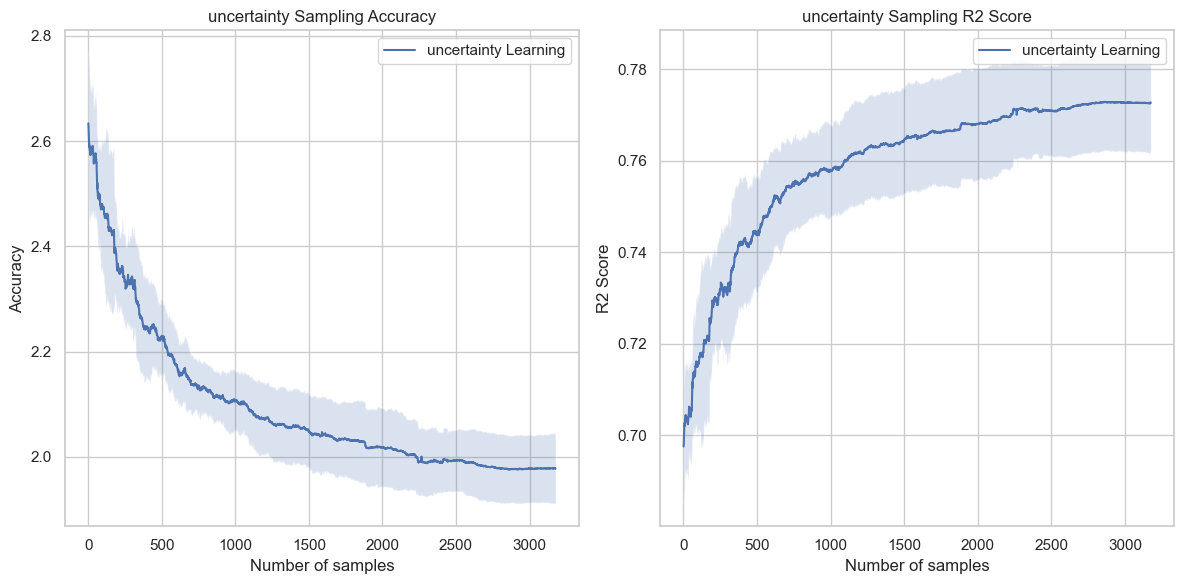

In [74]:
# Calculate the mean and standard deviation of accuracy and F1 scores
mse_uncertainty = np.array(mse_uncertainty)
mean_mse_uncertainty = np.mean(mse_uncertainty, axis=0)
std_mse_uncertainty = np.std(mse_uncertainty, axis=0)
r2_uncertainty = np.array(r2_uncertainty)
mean_r2_uncertainty = np.mean(r2_uncertainty, axis=0)
std_r2_uncertainty = np.std(r2_uncertainty, axis=0)
print(f'Mean MSE of the model: {mean_mse_uncertainty[-1]:.4f}')
print(f'Mean R2 Score of the model: {mean_r2_uncertainty[-1]:.4f}')

# Plot the results (updated for classification metrics)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(mean_mse_uncertainty) + 1), mean_mse_uncertainty, label='uncertainty Learning')
plt.fill_between(range(1, len(mean_mse_uncertainty) + 1), 
                 mean_mse_uncertainty - std_mse_uncertainty,
                 mean_mse_uncertainty + std_mse_uncertainty, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.title('uncertainty Sampling Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(mean_r2_uncertainty) + 1), mean_r2_uncertainty, label='uncertainty Learning')
plt.fill_between(range(1, len(mean_r2_uncertainty) + 1),
                 mean_r2_uncertainty - std_r2_uncertainty,
                 mean_r2_uncertainty + std_r2_uncertainty, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('R2 Score')
plt.title('uncertainty Sampling R2 Score')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/uncertainty_Sampling_Results_regression.png', dpi=300)
plt.show()

## Plot

In [75]:
def plot_learning_curves(result_dict, 
                        save_path=None, 
                        dpi=300):
    """
    Plot learning curves for accuracy and F1 score across multiple experiments with std deviation bands.
    
    Args:
        result_dict: Dictionary containing experimental results in format:
            {
                "experiment1": {
                    "MSE": [n_runs arrays of length n_samples],
                    "r2": [n_runs arrays of length n_samples]
                },
                ...
            }
        save_path: Path to save the figure (if None, figure won't be saved)
        dpi: Resolution of the output figure
    """
    plt.figure(figsize=(12, 6))
    
    # Left plot - Accuracy
    plt.subplot(1, 2, 1)
    for exp_name, results in result_dict.items():
        # Calculate mean and std across runs
        acc_data = np.array(results["accuracy"])
        mean_acc = np.mean(acc_data, axis=0)
        std_acc = np.std(acc_data, axis=0)
        
        # Plot without specifying color
        line = plt.plot(mean_acc, label=exp_name)[0]
        
        # Use the automatically assigned color for the fill
        plt.fill_between(np.arange(len(mean_acc)),
                        mean_acc - std_acc,
                        mean_acc + std_acc,
                        color=line.get_color(),  # Use the same color as line
                        alpha=0.2)
    
    plt.xlabel('Number of Samples')
    plt.ylabel('MSE')
    plt.title('MSE Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Right plot - F1 Score
    plt.subplot(1, 2, 2)
    for exp_name, results in result_dict.items():
        f1_data = np.array(results["f1"])
        mean_f1 = np.mean(f1_data, axis=0)
        std_f1 = np.std(f1_data, axis=0)
        
        # Get the same color as used in accuracy plot
        line = plt.plot(mean_f1, label=exp_name)[0]
        
        plt.fill_between(np.arange(len(mean_f1)),
                        mean_f1 - std_f1,
                        mean_f1 + std_f1,
                        color=line.get_color(),
                        alpha=0.2)
    
    plt.xlabel('Number of Samples')
    plt.ylabel('R2 Score')
    plt.title('R2 Score Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()

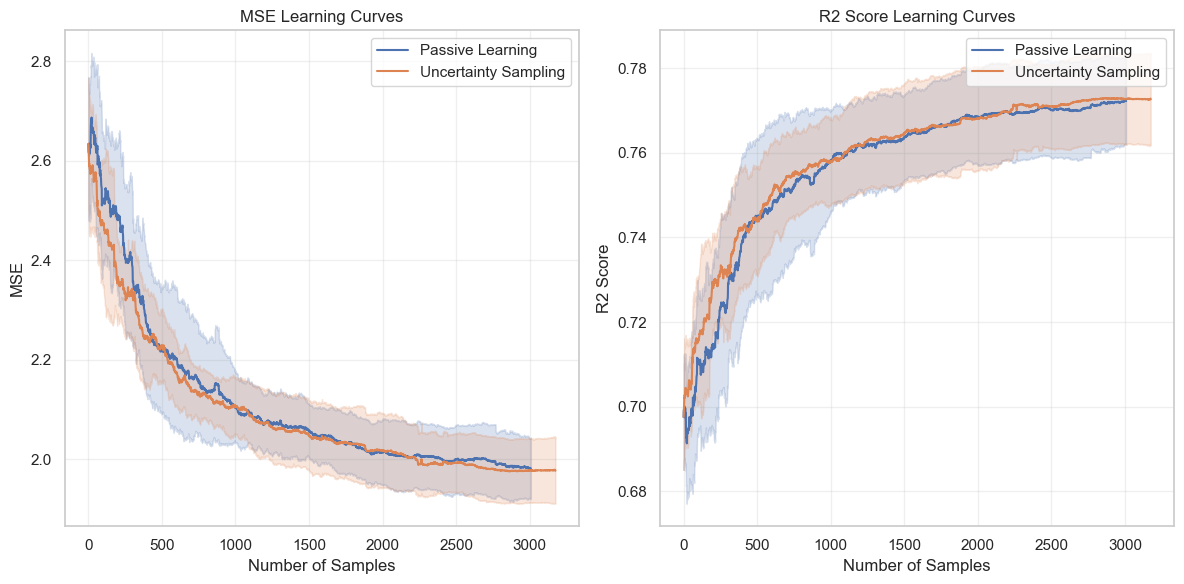

In [76]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

result_dict = {
    "Passive Learning": {
        "accuracy": mse_passive,
        "f1": r2_passive
    },
    "Uncertainty Sampling": {
        "accuracy": mse_uncertainty,
        "f1": r2_uncertainty
    }
}

plot_learning_curves(result_dict, save_path=None)

/opt/anaconda3/envs/UCL/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


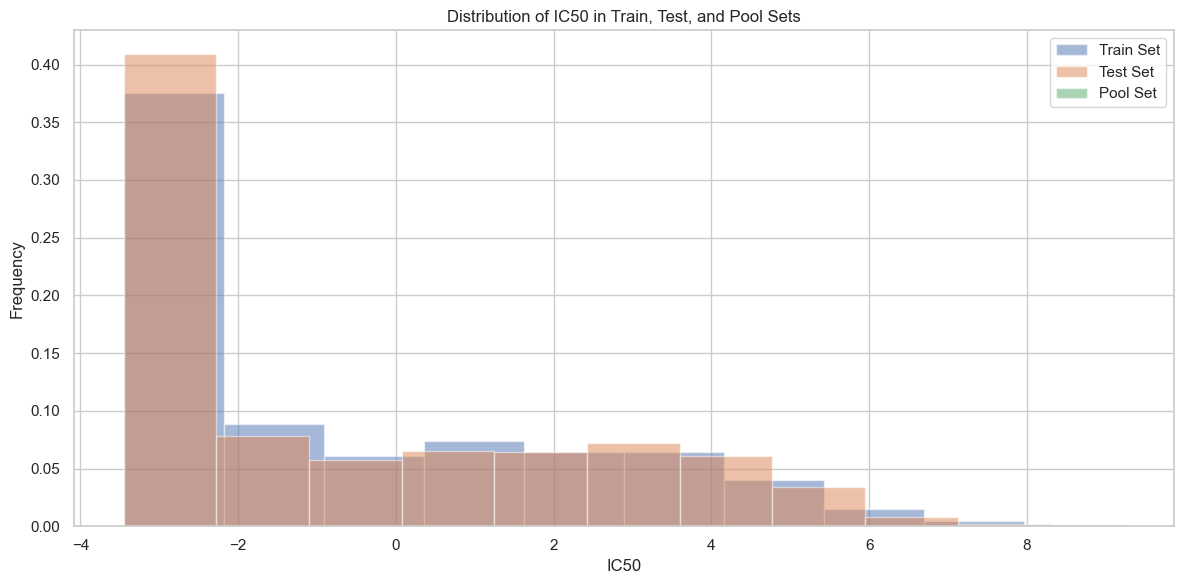

In [94]:
# plot the distribution of the IC50 in X_encoded
plt.figure(figsize=(12, 6))
# plt.subplot(1, 1, 1)
plt.hist(y_train, alpha=0.5, label='Train Set', density=True)
plt.hist(y_test, alpha=0.5, label='Test Set', density=True)
plt.hist(y_pool, alpha=0.5, label='Pool Set', density=True)
plt.xlabel('IC50')
plt.ylabel('Frequency')
plt.title('Distribution of IC50 in Train, Test, and Pool Sets')
plt.legend()
plt.tight_layout()
# plt.savefig('./figures/Distribution_of_IC50.png', dpi=300)
plt.show()